<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[03:10:13] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


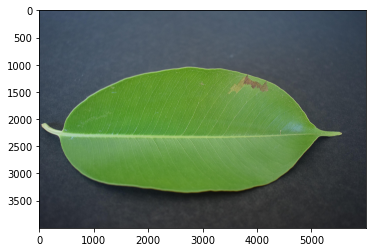

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

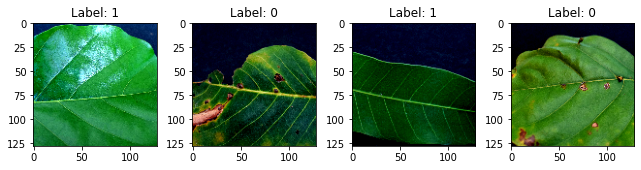

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[03:10:19] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[03:10:21] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2597296853276756 samples/sec                   batch loss = 0.7733121514320374 | accuracy = 0.75


Epoch[1] Batch[10] Speed: 1.2624009146175144 samples/sec                   batch loss = 0.6984460353851318 | accuracy = 0.625


Epoch[1] Batch[15] Speed: 1.2244454760945735 samples/sec                   batch loss = 0.5223854184150696 | accuracy = 0.6833333333333333


Epoch[1] Batch[20] Speed: 1.2638575445907638 samples/sec                   batch loss = 0.7381637692451477 | accuracy = 0.6375


Epoch[1] Batch[25] Speed: 1.2641269472424237 samples/sec                   batch loss = 0.3998255133628845 | accuracy = 0.68


Epoch[1] Batch[30] Speed: 1.2578781128277474 samples/sec                   batch loss = 0.5831279754638672 | accuracy = 0.6666666666666666


Epoch[1] Batch[35] Speed: 1.2638774435095037 samples/sec                   batch loss = 1.0204949378967285 | accuracy = 0.6357142857142857


Epoch[1] Batch[40] Speed: 1.266463817661753 samples/sec                   batch loss = 0.6350343227386475 | accuracy = 0.64375


Epoch[1] Batch[45] Speed: 1.2647150036824542 samples/sec                   batch loss = 0.932968258857727 | accuracy = 0.6666666666666666


Epoch[1] Batch[50] Speed: 1.2682354020818387 samples/sec                   batch loss = 0.1462816447019577 | accuracy = 0.67


Epoch[1] Batch[55] Speed: 1.2701029029771065 samples/sec                   batch loss = 0.783087432384491 | accuracy = 0.6545454545454545


Epoch[1] Batch[60] Speed: 1.2570112482964222 samples/sec                   batch loss = 0.6584809422492981 | accuracy = 0.6416666666666667


Epoch[1] Batch[65] Speed: 1.2582292322103137 samples/sec                   batch loss = 1.3895965814590454 | accuracy = 0.6346153846153846


Epoch[1] Batch[70] Speed: 1.2592600431957337 samples/sec                   batch loss = 0.6220532655715942 | accuracy = 0.65


Epoch[1] Batch[75] Speed: 1.264875382315103 samples/sec                   batch loss = 0.6224867701530457 | accuracy = 0.6566666666666666


Epoch[1] Batch[80] Speed: 1.2647493262471494 samples/sec                   batch loss = 0.6377506256103516 | accuracy = 0.66875


Epoch[1] Batch[85] Speed: 1.2672227762101456 samples/sec                   batch loss = 0.4023458659648895 | accuracy = 0.6676470588235294


Epoch[1] Batch[90] Speed: 1.260461367848559 samples/sec                   batch loss = 0.508929431438446 | accuracy = 0.6694444444444444


Epoch[1] Batch[95] Speed: 1.2593567417391855 samples/sec                   batch loss = 0.5155712962150574 | accuracy = 0.6710526315789473


Epoch[1] Batch[100] Speed: 1.2625791397098038 samples/sec                   batch loss = 0.6306697130203247 | accuracy = 0.6825


Epoch[1] Batch[105] Speed: 1.2606830940343112 samples/sec                   batch loss = 0.3680241107940674 | accuracy = 0.680952380952381


Epoch[1] Batch[110] Speed: 1.2648911172493056 samples/sec                   batch loss = 0.5165963172912598 | accuracy = 0.6772727272727272


Epoch[1] Batch[115] Speed: 1.2648575498629195 samples/sec                   batch loss = 0.6906905174255371 | accuracy = 0.6739130434782609


Epoch[1] Batch[120] Speed: 1.2566826462128475 samples/sec                   batch loss = 0.14581729471683502 | accuracy = 0.675


Epoch[1] Batch[125] Speed: 1.2601191288082492 samples/sec                   batch loss = 0.5442942976951599 | accuracy = 0.668


Epoch[1] Batch[130] Speed: 1.2539806103025697 samples/sec                   batch loss = 0.2358068823814392 | accuracy = 0.6692307692307692


Epoch[1] Batch[135] Speed: 1.2640503714988451 samples/sec                   batch loss = 0.17049428820610046 | accuracy = 0.6703703703703704


Epoch[1] Batch[140] Speed: 1.2557001255758804 samples/sec                   batch loss = 1.597145438194275 | accuracy = 0.6696428571428571


Epoch[1] Batch[145] Speed: 1.255532857089617 samples/sec                   batch loss = 0.8554834127426147 | accuracy = 0.6637931034482759


Epoch[1] Batch[150] Speed: 1.2681154808474473 samples/sec                   batch loss = 0.7387575507164001 | accuracy = 0.665


Epoch[1] Batch[155] Speed: 1.271334070496033 samples/sec                   batch loss = 0.6355600357055664 | accuracy = 0.6645161290322581


Epoch[1] Batch[160] Speed: 1.2694983953087051 samples/sec                   batch loss = 0.4543669819831848 | accuracy = 0.6671875


Epoch[1] Batch[165] Speed: 1.266194469328934 samples/sec                   batch loss = 0.5086919069290161 | accuracy = 0.6651515151515152


Epoch[1] Batch[170] Speed: 1.2642791738440984 samples/sec                   batch loss = 0.3020678162574768 | accuracy = 0.6661764705882353


Epoch[1] Batch[175] Speed: 1.2701621353166697 samples/sec                   batch loss = 0.958284318447113 | accuracy = 0.6642857142857143


Epoch[1] Batch[180] Speed: 1.2584849122901243 samples/sec                   batch loss = 0.7690751552581787 | accuracy = 0.6638888888888889


Epoch[1] Batch[185] Speed: 1.268938130211177 samples/sec                   batch loss = 0.9153709411621094 | accuracy = 0.6594594594594595


Epoch[1] Batch[190] Speed: 1.2646269176259601 samples/sec                   batch loss = 0.4073197841644287 | accuracy = 0.6618421052631579


Epoch[1] Batch[195] Speed: 1.270475312340407 samples/sec                   batch loss = 0.9567887187004089 | accuracy = 0.6615384615384615


Epoch[1] Batch[200] Speed: 1.2554508366409127 samples/sec                   batch loss = 0.17859481275081635 | accuracy = 0.66


Epoch[1] Batch[205] Speed: 1.26475094708099 samples/sec                   batch loss = 0.48542627692222595 | accuracy = 0.6621951219512195


Epoch[1] Batch[210] Speed: 1.2661212737935212 samples/sec                   batch loss = 0.5838084816932678 | accuracy = 0.6607142857142857


Epoch[1] Batch[215] Speed: 1.2615253409785332 samples/sec                   batch loss = 0.4949879050254822 | accuracy = 0.6593023255813953


Epoch[1] Batch[220] Speed: 1.2596221482523973 samples/sec                   batch loss = 0.3944941759109497 | accuracy = 0.6636363636363637


Epoch[1] Batch[225] Speed: 1.2575889309012616 samples/sec                   batch loss = 0.7234740257263184 | accuracy = 0.6655555555555556


Epoch[1] Batch[230] Speed: 1.2662293500742845 samples/sec                   batch loss = 0.3907660245895386 | accuracy = 0.6684782608695652


Epoch[1] Batch[235] Speed: 1.26959715308782 samples/sec                   batch loss = 0.5654378533363342 | accuracy = 0.6712765957446809


Epoch[1] Batch[240] Speed: 1.2648003368334713 samples/sec                   batch loss = 0.4559696316719055 | accuracy = 0.66875


Epoch[1] Batch[245] Speed: 1.2675869857808748 samples/sec                   batch loss = 0.46260544657707214 | accuracy = 0.6704081632653062


Epoch[1] Batch[250] Speed: 1.270874991127775 samples/sec                   batch loss = 0.6684114933013916 | accuracy = 0.672


Epoch[1] Batch[255] Speed: 1.271131117869546 samples/sec                   batch loss = 0.34909453988075256 | accuracy = 0.6725490196078432


Epoch[1] Batch[260] Speed: 1.2656451361401573 samples/sec                   batch loss = 0.48506176471710205 | accuracy = 0.6711538461538461


Epoch[1] Batch[265] Speed: 1.2575898735672584 samples/sec                   batch loss = 0.40174028277397156 | accuracy = 0.6707547169811321


Epoch[1] Batch[270] Speed: 1.2584798146622225 samples/sec                   batch loss = 1.2680435180664062 | accuracy = 0.674074074074074


Epoch[1] Batch[275] Speed: 1.2621078456780266 samples/sec                   batch loss = 0.7779077887535095 | accuracy = 0.6754545454545454


Epoch[1] Batch[280] Speed: 1.2599147261160732 samples/sec                   batch loss = 0.6596018671989441 | accuracy = 0.6776785714285715


Epoch[1] Batch[285] Speed: 1.2623039379884715 samples/sec                   batch loss = 0.23493748903274536 | accuracy = 0.6789473684210526


Epoch[1] Batch[290] Speed: 1.2621150615548693 samples/sec                   batch loss = 0.9889971613883972 | accuracy = 0.6775862068965517


Epoch[1] Batch[295] Speed: 1.2690130916110216 samples/sec                   batch loss = 0.5564318299293518 | accuracy = 0.6779661016949152


Epoch[1] Batch[300] Speed: 1.2634906218452209 samples/sec                   batch loss = 0.20786382257938385 | accuracy = 0.6783333333333333


Epoch[1] Batch[305] Speed: 1.2656797956591295 samples/sec                   batch loss = 0.3869107961654663 | accuracy = 0.680327868852459


Epoch[1] Batch[310] Speed: 1.2591544763089575 samples/sec                   batch loss = 0.5478394627571106 | accuracy = 0.6830645161290323


Epoch[1] Batch[315] Speed: 1.2612687085720438 samples/sec                   batch loss = 0.4220089316368103 | accuracy = 0.6825396825396826


Epoch[1] Batch[320] Speed: 1.2611970294858612 samples/sec                   batch loss = 1.1844865083694458 | accuracy = 0.68046875


Epoch[1] Batch[325] Speed: 1.2634872914862372 samples/sec                   batch loss = 0.17399856448173523 | accuracy = 0.6815384615384615


Epoch[1] Batch[330] Speed: 1.2583976919046775 samples/sec                   batch loss = 0.8742892742156982 | accuracy = 0.6803030303030303


Epoch[1] Batch[335] Speed: 1.2614390264826605 samples/sec                   batch loss = 0.6368691325187683 | accuracy = 0.6798507462686567


Epoch[1] Batch[340] Speed: 1.2621908332436187 samples/sec                   batch loss = 0.4378233551979065 | accuracy = 0.6816176470588236


Epoch[1] Batch[345] Speed: 1.2673003111821628 samples/sec                   batch loss = 0.6883618831634521 | accuracy = 0.6833333333333333


Epoch[1] Batch[350] Speed: 1.2671912863196841 samples/sec                   batch loss = 0.6819847226142883 | accuracy = 0.6842857142857143


Epoch[1] Batch[355] Speed: 1.2666449131992863 samples/sec                   batch loss = 0.5877552628517151 | accuracy = 0.6845070422535211


Epoch[1] Batch[360] Speed: 1.272608362227146 samples/sec                   batch loss = 0.15684175491333008 | accuracy = 0.6875


Epoch[1] Batch[365] Speed: 1.263042703498426 samples/sec                   batch loss = 0.4721527099609375 | accuracy = 0.6883561643835616


Epoch[1] Batch[370] Speed: 1.2663534073087963 samples/sec                   batch loss = 0.2682923674583435 | accuracy = 0.6905405405405406


Epoch[1] Batch[375] Speed: 1.2671659232601447 samples/sec                   batch loss = 0.6468949913978577 | accuracy = 0.69


Epoch[1] Batch[380] Speed: 1.2690114598345306 samples/sec                   batch loss = 0.3479580879211426 | accuracy = 0.6888157894736842


Epoch[1] Batch[385] Speed: 1.2635680814324763 samples/sec                   batch loss = 0.6920941472053528 | accuracy = 0.688961038961039


Epoch[1] Batch[390] Speed: 1.2674065782215562 samples/sec                   batch loss = 0.33580175042152405 | accuracy = 0.6884615384615385


Epoch[1] Batch[395] Speed: 1.270986191375314 samples/sec                   batch loss = 0.7455654740333557 | accuracy = 0.6886075949367089


Epoch[1] Batch[400] Speed: 1.2665007209985486 samples/sec                   batch loss = 0.5884932279586792 | accuracy = 0.689375


Epoch[1] Batch[405] Speed: 1.268655736772712 samples/sec                   batch loss = 0.7299003005027771 | accuracy = 0.6895061728395062


Epoch[1] Batch[410] Speed: 1.2555977857997362 samples/sec                   batch loss = 0.4132721424102783 | accuracy = 0.6908536585365853


Epoch[1] Batch[415] Speed: 1.2554258474314686 samples/sec                   batch loss = 0.5492989420890808 | accuracy = 0.6903614457831325


Epoch[1] Batch[420] Speed: 1.2567283012663377 samples/sec                   batch loss = 0.5891995429992676 | accuracy = 0.6892857142857143


Epoch[1] Batch[425] Speed: 1.26039063267685 samples/sec                   batch loss = 0.5008091926574707 | accuracy = 0.69


Epoch[1] Batch[430] Speed: 1.270170886017012 samples/sec                   batch loss = 0.3846195936203003 | accuracy = 0.6906976744186046


Epoch[1] Batch[435] Speed: 1.2687725938363115 samples/sec                   batch loss = 0.7443392872810364 | accuracy = 0.6913793103448276


Epoch[1] Batch[440] Speed: 1.2683947569861176 samples/sec                   batch loss = 0.4060113728046417 | accuracy = 0.6914772727272728


Epoch[1] Batch[445] Speed: 1.2758092733417925 samples/sec                   batch loss = 0.3250071108341217 | accuracy = 0.6938202247191011


Epoch[1] Batch[450] Speed: 1.2666645174592774 samples/sec                   batch loss = 0.48542869091033936 | accuracy = 0.6927777777777778


Epoch[1] Batch[455] Speed: 1.2686051821366782 samples/sec                   batch loss = 0.8255541324615479 | accuracy = 0.6939560439560439


Epoch[1] Batch[460] Speed: 1.2607846538098397 samples/sec                   batch loss = 0.565209150314331 | accuracy = 0.6951086956521739


Epoch[1] Batch[465] Speed: 1.271921138720558 samples/sec                   batch loss = 0.647571325302124 | accuracy = 0.696236559139785


Epoch[1] Batch[470] Speed: 1.2713868661372738 samples/sec                   batch loss = 0.3438093066215515 | accuracy = 0.6973404255319149


Epoch[1] Batch[475] Speed: 1.2647037539138448 samples/sec                   batch loss = 0.8877204060554504 | accuracy = 0.6968421052631579


Epoch[1] Batch[480] Speed: 1.25863701051864 samples/sec                   batch loss = 0.5245102643966675 | accuracy = 0.696875


Epoch[1] Batch[485] Speed: 1.2637319768733322 samples/sec                   batch loss = 0.35489749908447266 | accuracy = 0.6989690721649484


Epoch[1] Batch[490] Speed: 1.2691527680329218 samples/sec                   batch loss = 0.27587059140205383 | accuracy = 0.7005102040816327


Epoch[1] Batch[495] Speed: 1.2695763050788074 samples/sec                   batch loss = 0.338495671749115 | accuracy = 0.6994949494949495


Epoch[1] Batch[500] Speed: 1.268508496825821 samples/sec                   batch loss = 0.42708468437194824 | accuracy = 0.701


Epoch[1] Batch[505] Speed: 1.25818318497357 samples/sec                   batch loss = 0.30484095215797424 | accuracy = 0.7019801980198019


Epoch[1] Batch[510] Speed: 1.268116151806447 samples/sec                   batch loss = 0.1387873888015747 | accuracy = 0.7024509803921568


Epoch[1] Batch[515] Speed: 1.266563346866974 samples/sec                   batch loss = 0.7482916116714478 | accuracy = 0.7024271844660194


Epoch[1] Batch[520] Speed: 1.2653062794418244 samples/sec                   batch loss = 0.3674139976501465 | accuracy = 0.7019230769230769


Epoch[1] Batch[525] Speed: 1.2654713897551162 samples/sec                   batch loss = 0.4883146584033966 | accuracy = 0.7023809523809523


Epoch[1] Batch[530] Speed: 1.268683653867749 samples/sec                   batch loss = 0.33788159489631653 | accuracy = 0.7028301886792453


Epoch[1] Batch[535] Speed: 1.2607547147125484 samples/sec                   batch loss = 0.2871802747249603 | accuracy = 0.702803738317757


Epoch[1] Batch[540] Speed: 1.2612024335774268 samples/sec                   batch loss = 0.5914168953895569 | accuracy = 0.7037037037037037


Epoch[1] Batch[545] Speed: 1.2560015092486396 samples/sec                   batch loss = 0.23627124726772308 | accuracy = 0.7045871559633028


Epoch[1] Batch[550] Speed: 1.267851369861875 samples/sec                   batch loss = 0.5205632448196411 | accuracy = 0.7045454545454546


Epoch[1] Batch[555] Speed: 1.2627898256142596 samples/sec                   batch loss = 1.3435271978378296 | accuracy = 0.7040540540540541


Epoch[1] Batch[560] Speed: 1.2682478652216926 samples/sec                   batch loss = 1.650610089302063 | accuracy = 0.7049107142857143


Epoch[1] Batch[565] Speed: 1.2738897571455396 samples/sec                   batch loss = 0.5511860251426697 | accuracy = 0.7053097345132744


Epoch[1] Batch[570] Speed: 1.271954407045037 samples/sec                   batch loss = 0.439437597990036 | accuracy = 0.7048245614035088


Epoch[1] Batch[575] Speed: 1.2651580986118354 samples/sec                   batch loss = 0.4522112309932709 | accuracy = 0.7052173913043478


Epoch[1] Batch[580] Speed: 1.261279233568285 samples/sec                   batch loss = 0.674751341342926 | accuracy = 0.7051724137931035


Epoch[1] Batch[585] Speed: 1.2641412347887009 samples/sec                   batch loss = 0.3878909647464752 | accuracy = 0.7068376068376069


Epoch[1] Batch[590] Speed: 1.2657241014998528 samples/sec                   batch loss = 0.3056604862213135 | accuracy = 0.7072033898305085


Epoch[1] Batch[595] Speed: 1.2651371099292492 samples/sec                   batch loss = 0.7651522755622864 | accuracy = 0.7058823529411765


Epoch[1] Batch[600] Speed: 1.2676202193135324 samples/sec                   batch loss = 0.1739783138036728 | accuracy = 0.7054166666666667


Epoch[1] Batch[605] Speed: 1.271819608769461 samples/sec                   batch loss = 0.6651352047920227 | accuracy = 0.7070247933884297


Epoch[1] Batch[610] Speed: 1.262723675782917 samples/sec                   batch loss = 0.3144912123680115 | accuracy = 0.7081967213114754


Epoch[1] Batch[615] Speed: 1.2702400304060217 samples/sec                   batch loss = 0.526204526424408 | accuracy = 0.7073170731707317


Epoch[1] Batch[620] Speed: 1.2669330134312653 samples/sec                   batch loss = 0.19523268938064575 | accuracy = 0.7080645161290322


Epoch[1] Batch[625] Speed: 1.2594977043384283 samples/sec                   batch loss = 1.0432177782058716 | accuracy = 0.708


Epoch[1] Batch[630] Speed: 1.263402230553593 samples/sec                   batch loss = 0.7528379559516907 | accuracy = 0.7075396825396826


Epoch[1] Batch[635] Speed: 1.2579879934438802 samples/sec                   batch loss = 0.7955686450004578 | accuracy = 0.7066929133858267


Epoch[1] Batch[640] Speed: 1.2657682194491078 samples/sec                   batch loss = 0.6153070330619812 | accuracy = 0.7078125


Epoch[1] Batch[645] Speed: 1.264798620522554 samples/sec                   batch loss = 0.6629593968391418 | accuracy = 0.7077519379844961


Epoch[1] Batch[650] Speed: 1.2641543796165209 samples/sec                   batch loss = 0.7510735392570496 | accuracy = 0.7084615384615385


Epoch[1] Batch[655] Speed: 1.2652375757072083 samples/sec                   batch loss = 0.753248393535614 | accuracy = 0.7083969465648855


Epoch[1] Batch[660] Speed: 1.2664025399283043 samples/sec                   batch loss = 0.7278751134872437 | accuracy = 0.706060606060606


Epoch[1] Batch[665] Speed: 1.2653225976752815 samples/sec                   batch loss = 0.28757530450820923 | accuracy = 0.706015037593985


Epoch[1] Batch[670] Speed: 1.2668939802280395 samples/sec                   batch loss = 0.43311047554016113 | accuracy = 0.7055970149253732


Epoch[1] Batch[675] Speed: 1.2692002938255036 samples/sec                   batch loss = 0.37884652614593506 | accuracy = 0.7055555555555556


Epoch[1] Batch[680] Speed: 1.2651063913857143 samples/sec                   batch loss = 0.46320369839668274 | accuracy = 0.705514705882353


Epoch[1] Batch[685] Speed: 1.2636260395952652 samples/sec                   batch loss = 0.9786202907562256 | accuracy = 0.7065693430656934


Epoch[1] Batch[690] Speed: 1.2695285589927805 samples/sec                   batch loss = 0.4815438985824585 | accuracy = 0.7076086956521739


Epoch[1] Batch[695] Speed: 1.2642574521618057 samples/sec                   batch loss = 0.2799951136112213 | accuracy = 0.708273381294964


Epoch[1] Batch[700] Speed: 1.257371872555381 samples/sec                   batch loss = 0.5790024399757385 | accuracy = 0.7082142857142857


Epoch[1] Batch[705] Speed: 1.2696078175414605 samples/sec                   batch loss = 0.7727850079536438 | accuracy = 0.7081560283687943


Epoch[1] Batch[710] Speed: 1.2658444304241192 samples/sec                   batch loss = 0.27877339720726013 | accuracy = 0.7088028169014085


Epoch[1] Batch[715] Speed: 1.2604765196540373 samples/sec                   batch loss = 0.7061380743980408 | accuracy = 0.7087412587412587


Epoch[1] Batch[720] Speed: 1.2655557748979636 samples/sec                   batch loss = 0.8414213061332703 | accuracy = 0.7083333333333334


Epoch[1] Batch[725] Speed: 1.260422637701485 samples/sec                   batch loss = 1.1705821752548218 | accuracy = 0.7086206896551724


Epoch[1] Batch[730] Speed: 1.2676326703652725 samples/sec                   batch loss = 0.6950058937072754 | accuracy = 0.7075342465753425


Epoch[1] Batch[735] Speed: 1.267903780816667 samples/sec                   batch loss = 0.47500109672546387 | accuracy = 0.7081632653061225


Epoch[1] Batch[740] Speed: 1.2720115940578558 samples/sec                   batch loss = 1.76760995388031 | accuracy = 0.7081081081081081


Epoch[1] Batch[745] Speed: 1.2610626057621184 samples/sec                   batch loss = 1.3330230712890625 | accuracy = 0.7080536912751678


Epoch[1] Batch[750] Speed: 1.265266010514612 samples/sec                   batch loss = 0.4876883327960968 | accuracy = 0.7076666666666667


Epoch[1] Batch[755] Speed: 1.2676448343212479 samples/sec                   batch loss = 1.0642889738082886 | accuracy = 0.706953642384106


Epoch[1] Batch[760] Speed: 1.2616480037612072 samples/sec                   batch loss = 0.38812094926834106 | accuracy = 0.7069078947368421


Epoch[1] Batch[765] Speed: 1.26383488534106 samples/sec                   batch loss = 0.2561570703983307 | accuracy = 0.707843137254902


Epoch[1] Batch[770] Speed: 1.2666788624242291 samples/sec                   batch loss = 0.7348182201385498 | accuracy = 0.7071428571428572


Epoch[1] Batch[775] Speed: 1.2673516234915032 samples/sec                   batch loss = 0.507333517074585 | accuracy = 0.707741935483871


Epoch[1] Batch[780] Speed: 1.264961500110269 samples/sec                   batch loss = 0.5678830146789551 | accuracy = 0.7057692307692308


Epoch[1] Batch[785] Speed: 1.2623949303197368 samples/sec                   batch loss = 0.6984683871269226 | accuracy = 0.7060509554140127


[Epoch 1] training: accuracy=0.7062182741116751
[Epoch 1] time cost: 649.9218473434448
[Epoch 1] validation: validation accuracy=0.7


Epoch[2] Batch[5] Speed: 1.2705629641533491 samples/sec                   batch loss = 0.48691412806510925 | accuracy = 0.8


Epoch[2] Batch[10] Speed: 1.2682075047104568 samples/sec                   batch loss = 0.8402987122535706 | accuracy = 0.675


Epoch[2] Batch[15] Speed: 1.269586969182208 samples/sec                   batch loss = 0.9556846618652344 | accuracy = 0.6666666666666666


Epoch[2] Batch[20] Speed: 1.267134149086228 samples/sec                   batch loss = 0.4036146402359009 | accuracy = 0.675


Epoch[2] Batch[25] Speed: 1.2641720969908992 samples/sec                   batch loss = 0.4417452812194824 | accuracy = 0.68


Epoch[2] Batch[30] Speed: 1.2610976783007324 samples/sec                   batch loss = 0.5812777876853943 | accuracy = 0.675


Epoch[2] Batch[35] Speed: 1.269585720223899 samples/sec                   batch loss = 0.22508306801319122 | accuracy = 0.6928571428571428


Epoch[2] Batch[40] Speed: 1.2689961981281697 samples/sec                   batch loss = 0.2666589021682739 | accuracy = 0.69375


Epoch[2] Batch[45] Speed: 1.2681060874960015 samples/sec                   batch loss = 0.3253590166568756 | accuracy = 0.7111111111111111


Epoch[2] Batch[50] Speed: 1.2658567511050733 samples/sec                   batch loss = 0.41078609228134155 | accuracy = 0.695


Epoch[2] Batch[55] Speed: 1.2664124816224605 samples/sec                   batch loss = 0.44274502992630005 | accuracy = 0.7


Epoch[2] Batch[60] Speed: 1.2631910549425696 samples/sec                   batch loss = 0.9066675305366516 | accuracy = 0.6833333333333333


Epoch[2] Batch[65] Speed: 1.2662056500709096 samples/sec                   batch loss = 0.5735966563224792 | accuracy = 0.6807692307692308


Epoch[2] Batch[70] Speed: 1.2662814358602783 samples/sec                   batch loss = 0.7112434506416321 | accuracy = 0.6785714285714286


Epoch[2] Batch[75] Speed: 1.2664781580811921 samples/sec                   batch loss = 0.6113744974136353 | accuracy = 0.69


Epoch[2] Batch[80] Speed: 1.2702360873386038 samples/sec                   batch loss = 0.5477773547172546 | accuracy = 0.6875


Epoch[2] Batch[85] Speed: 1.2676892778457736 samples/sec                   batch loss = 0.4540956914424896 | accuracy = 0.6941176470588235


Epoch[2] Batch[90] Speed: 1.2728685681683773 samples/sec                   batch loss = 0.2637786567211151 | accuracy = 0.7055555555555556


Epoch[2] Batch[95] Speed: 1.2662208447290735 samples/sec                   batch loss = 0.4299522638320923 | accuracy = 0.7


Epoch[2] Batch[100] Speed: 1.269106877817149 samples/sec                   batch loss = 0.18072430789470673 | accuracy = 0.7


Epoch[2] Batch[105] Speed: 1.274737641977709 samples/sec                   batch loss = 0.3772945702075958 | accuracy = 0.7047619047619048


Epoch[2] Batch[110] Speed: 1.267164200523113 samples/sec                   batch loss = 0.6781362891197205 | accuracy = 0.7113636363636363


Epoch[2] Batch[115] Speed: 1.2651922544112992 samples/sec                   batch loss = 0.45655739307403564 | accuracy = 0.7130434782608696


Epoch[2] Batch[120] Speed: 1.270122133650528 samples/sec                   batch loss = 0.5639582276344299 | accuracy = 0.7125


Epoch[2] Batch[125] Speed: 1.2649690347830715 samples/sec                   batch loss = 0.26941409707069397 | accuracy = 0.714


Epoch[2] Batch[130] Speed: 1.271469054939382 samples/sec                   batch loss = 0.28379905223846436 | accuracy = 0.7192307692307692


Epoch[2] Batch[135] Speed: 1.2681886195577612 samples/sec                   batch loss = 0.44096195697784424 | accuracy = 0.7203703703703703


Epoch[2] Batch[140] Speed: 1.2694252975491713 samples/sec                   batch loss = 0.8147581815719604 | accuracy = 0.7196428571428571


Epoch[2] Batch[145] Speed: 1.267207557496244 samples/sec                   batch loss = 0.5743176341056824 | accuracy = 0.7155172413793104


Epoch[2] Batch[150] Speed: 1.2622909265872575 samples/sec                   batch loss = 0.7032917737960815 | accuracy = 0.7166666666666667


Epoch[2] Batch[155] Speed: 1.2679971156214522 samples/sec                   batch loss = 0.4195234775543213 | accuracy = 0.7064516129032258


Epoch[2] Batch[160] Speed: 1.2715564584413983 samples/sec                   batch loss = 1.052314043045044 | accuracy = 0.703125


Epoch[2] Batch[165] Speed: 1.276111846717034 samples/sec                   batch loss = 0.39797306060791016 | accuracy = 0.7


Epoch[2] Batch[170] Speed: 1.2694798559211502 samples/sec                   batch loss = 0.3065398335456848 | accuracy = 0.7044117647058824


Epoch[2] Batch[175] Speed: 1.263396331897933 samples/sec                   batch loss = 0.5590623021125793 | accuracy = 0.7085714285714285


Epoch[2] Batch[180] Speed: 1.2706625612961637 samples/sec                   batch loss = 0.5634591579437256 | accuracy = 0.7097222222222223


Epoch[2] Batch[185] Speed: 1.2707050993268538 samples/sec                   batch loss = 0.4365932047367096 | accuracy = 0.7121621621621622


Epoch[2] Batch[190] Speed: 1.264348726356693 samples/sec                   batch loss = 0.3460513949394226 | accuracy = 0.7144736842105263


Epoch[2] Batch[195] Speed: 1.2692963163871558 samples/sec                   batch loss = 0.4480281174182892 | accuracy = 0.7141025641025641


Epoch[2] Batch[200] Speed: 1.2614915725823521 samples/sec                   batch loss = 0.3556201756000519 | accuracy = 0.715


Epoch[2] Batch[205] Speed: 1.2658897984569728 samples/sec                   batch loss = 0.8997218608856201 | accuracy = 0.7170731707317073


Epoch[2] Batch[210] Speed: 1.2652706861589902 samples/sec                   batch loss = 0.7815902233123779 | accuracy = 0.7166666666666667


Epoch[2] Batch[215] Speed: 1.2715056723641038 samples/sec                   batch loss = 0.37139901518821716 | accuracy = 0.7209302325581395


Epoch[2] Batch[220] Speed: 1.2747776443184415 samples/sec                   batch loss = 0.33038821816444397 | accuracy = 0.7238636363636364


Epoch[2] Batch[225] Speed: 1.2732110048576735 samples/sec                   batch loss = 0.7066518068313599 | accuracy = 0.7266666666666667


Epoch[2] Batch[230] Speed: 1.2660433097901762 samples/sec                   batch loss = 0.7744598388671875 | accuracy = 0.7293478260869565


Epoch[2] Batch[235] Speed: 1.2680707199007144 samples/sec                   batch loss = 0.31960228085517883 | accuracy = 0.7308510638297873


Epoch[2] Batch[240] Speed: 1.2769251775776134 samples/sec                   batch loss = 0.43222877383232117 | accuracy = 0.7302083333333333


Epoch[2] Batch[245] Speed: 1.2765703469697425 samples/sec                   batch loss = 0.7075951099395752 | accuracy = 0.7316326530612245


Epoch[2] Batch[250] Speed: 1.2602552447862372 samples/sec                   batch loss = 0.5041371583938599 | accuracy = 0.733


Epoch[2] Batch[255] Speed: 1.2633021511476346 samples/sec                   batch loss = 0.15019477903842926 | accuracy = 0.734313725490196


Epoch[2] Batch[260] Speed: 1.262905509432451 samples/sec                   batch loss = 0.49517858028411865 | accuracy = 0.7326923076923076


Epoch[2] Batch[265] Speed: 1.25999193711672 samples/sec                   batch loss = 0.3570760190486908 | accuracy = 0.7330188679245283


Epoch[2] Batch[270] Speed: 1.2679998947944728 samples/sec                   batch loss = 0.22332610189914703 | accuracy = 0.7342592592592593


Epoch[2] Batch[275] Speed: 1.270880671015143 samples/sec                   batch loss = 0.7681484222412109 | accuracy = 0.7363636363636363


Epoch[2] Batch[280] Speed: 1.2703054311918547 samples/sec                   batch loss = 0.4239633083343506 | accuracy = 0.7392857142857143


Epoch[2] Batch[285] Speed: 1.2658368853193105 samples/sec                   batch loss = 0.45716753602027893 | accuracy = 0.7412280701754386


Epoch[2] Batch[290] Speed: 1.2679428762698821 samples/sec                   batch loss = 0.410504013299942 | accuracy = 0.7422413793103448


Epoch[2] Batch[295] Speed: 1.2633358262879504 samples/sec                   batch loss = 0.22067773342132568 | accuracy = 0.7457627118644068


Epoch[2] Batch[300] Speed: 1.264831517292769 samples/sec                   batch loss = 0.893480658531189 | accuracy = 0.7441666666666666


Epoch[2] Batch[305] Speed: 1.2671750155609687 samples/sec                   batch loss = 0.27031049132347107 | accuracy = 0.7442622950819672


Epoch[2] Batch[310] Speed: 1.2680176242884262 samples/sec                   batch loss = 0.388974130153656 | accuracy = 0.7451612903225806


Epoch[2] Batch[315] Speed: 1.2673902061920699 samples/sec                   batch loss = 0.30419227480888367 | accuracy = 0.7468253968253968


Epoch[2] Batch[320] Speed: 1.26768707475283 samples/sec                   batch loss = 0.3290254473686218 | accuracy = 0.74609375


Epoch[2] Batch[325] Speed: 1.2654366462023625 samples/sec                   batch loss = 0.5104928016662598 | accuracy = 0.7476923076923077


Epoch[2] Batch[330] Speed: 1.2664524411600124 samples/sec                   batch loss = 2.984560012817383 | accuracy = 0.7454545454545455


Epoch[2] Batch[335] Speed: 1.262416778030604 samples/sec                   batch loss = 0.28167441487312317 | accuracy = 0.7455223880597015


Epoch[2] Batch[340] Speed: 1.2678903662657388 samples/sec                   batch loss = 0.3132422864437103 | accuracy = 0.7470588235294118


Epoch[2] Batch[345] Speed: 1.2637236002334133 samples/sec                   batch loss = 0.8117402195930481 | accuracy = 0.7471014492753624


Epoch[2] Batch[350] Speed: 1.2653692644201555 samples/sec                   batch loss = 0.5163522958755493 | accuracy = 0.7478571428571429


Epoch[2] Batch[355] Speed: 1.270479353102082 samples/sec                   batch loss = 1.3754706382751465 | accuracy = 0.747887323943662


Epoch[2] Batch[360] Speed: 1.2621102193126181 samples/sec                   batch loss = 0.22119762003421783 | accuracy = 0.7479166666666667


Epoch[2] Batch[365] Speed: 1.2669656386154857 samples/sec                   batch loss = 1.063317060470581 | accuracy = 0.7458904109589041


Epoch[2] Batch[370] Speed: 1.264041990637455 samples/sec                   batch loss = 0.31475692987442017 | accuracy = 0.745945945945946


Epoch[2] Batch[375] Speed: 1.265427960612261 samples/sec                   batch loss = 0.3223327398300171 | accuracy = 0.7473333333333333


Epoch[2] Batch[380] Speed: 1.2674310891849943 samples/sec                   batch loss = 0.6848816871643066 | accuracy = 0.7453947368421052


Epoch[2] Batch[385] Speed: 1.2658014531820196 samples/sec                   batch loss = 0.5125157237052917 | accuracy = 0.7467532467532467


Epoch[2] Batch[390] Speed: 1.263589684264056 samples/sec                   batch loss = 0.2502559423446655 | accuracy = 0.7448717948717949


Epoch[2] Batch[395] Speed: 1.2652078064058645 samples/sec                   batch loss = 0.40686097741127014 | accuracy = 0.7443037974683544


Epoch[2] Batch[400] Speed: 1.2788090193405846 samples/sec                   batch loss = 0.5023436546325684 | accuracy = 0.744375


Epoch[2] Batch[405] Speed: 1.275314771104964 samples/sec                   batch loss = 0.46700412034988403 | accuracy = 0.7432098765432099


Epoch[2] Batch[410] Speed: 1.265892663915597 samples/sec                   batch loss = 0.4380999505519867 | accuracy = 0.7420731707317073


Epoch[2] Batch[415] Speed: 1.2640131346579697 samples/sec                   batch loss = 1.8345437049865723 | accuracy = 0.7409638554216867


Epoch[2] Batch[420] Speed: 1.2709277486460442 samples/sec                   batch loss = 0.25283199548721313 | accuracy = 0.7440476190476191


Epoch[2] Batch[425] Speed: 1.2680057406809353 samples/sec                   batch loss = 0.794783890247345 | accuracy = 0.7447058823529412


Epoch[2] Batch[430] Speed: 1.2691159019907472 samples/sec                   batch loss = 0.4491121470928192 | accuracy = 0.7436046511627907


Epoch[2] Batch[435] Speed: 1.2711635743777576 samples/sec                   batch loss = 0.988390326499939 | accuracy = 0.7436781609195402


Epoch[2] Batch[440] Speed: 1.2778167186421212 samples/sec                   batch loss = 0.24895671010017395 | accuracy = 0.7448863636363636


Epoch[2] Batch[445] Speed: 1.2660105410225675 samples/sec                   batch loss = 0.2764543890953064 | accuracy = 0.7432584269662922


Epoch[2] Batch[450] Speed: 1.2648529726300861 samples/sec                   batch loss = 0.3438646197319031 | accuracy = 0.7433333333333333


Epoch[2] Batch[455] Speed: 1.2676574774205434 samples/sec                   batch loss = 0.6044842600822449 | accuracy = 0.743956043956044


Epoch[2] Batch[460] Speed: 1.272185308234619 samples/sec                   batch loss = 0.31880509853363037 | accuracy = 0.7456521739130435


Epoch[2] Batch[465] Speed: 1.265043432573533 samples/sec                   batch loss = 0.12964162230491638 | accuracy = 0.7473118279569892


Epoch[2] Batch[470] Speed: 1.2693274308135802 samples/sec                   batch loss = 0.3049536645412445 | accuracy = 0.7484042553191489


Epoch[2] Batch[475] Speed: 1.2665545501879274 samples/sec                   batch loss = 0.5440967082977295 | accuracy = 0.748421052631579


Epoch[2] Batch[480] Speed: 1.2696147351206997 samples/sec                   batch loss = 0.23878584802150726 | accuracy = 0.7489583333333333


Epoch[2] Batch[485] Speed: 1.2717259032002934 samples/sec                   batch loss = 0.3359725773334503 | accuracy = 0.7489690721649485


Epoch[2] Batch[490] Speed: 1.2639627588945046 samples/sec                   batch loss = 1.23680579662323 | accuracy = 0.746938775510204


Epoch[2] Batch[495] Speed: 1.264997743662746 samples/sec                   batch loss = 0.3694908022880554 | accuracy = 0.7474747474747475


Epoch[2] Batch[500] Speed: 1.2728286855491309 samples/sec                   batch loss = 0.41314560174942017 | accuracy = 0.7485


Epoch[2] Batch[505] Speed: 1.2658631503130702 samples/sec                   batch loss = 0.5498673915863037 | accuracy = 0.748019801980198


Epoch[2] Batch[510] Speed: 1.2704198025736857 samples/sec                   batch loss = 0.9934417605400085 | accuracy = 0.7470588235294118


Epoch[2] Batch[515] Speed: 1.2707243482404895 samples/sec                   batch loss = 0.7699215412139893 | accuracy = 0.746116504854369


Epoch[2] Batch[520] Speed: 1.2617388066587847 samples/sec                   batch loss = 0.4491584300994873 | accuracy = 0.7461538461538462


Epoch[2] Batch[525] Speed: 1.2623040329631892 samples/sec                   batch loss = 0.40647393465042114 | accuracy = 0.7466666666666667


Epoch[2] Batch[530] Speed: 1.265433782807836 samples/sec                   batch loss = 0.6788045167922974 | accuracy = 0.7466981132075472


Epoch[2] Batch[535] Speed: 1.2665202251851064 samples/sec                   batch loss = 0.15331393480300903 | accuracy = 0.7476635514018691


Epoch[2] Batch[540] Speed: 1.2666639436674376 samples/sec                   batch loss = 0.20108452439308167 | accuracy = 0.7476851851851852


Epoch[2] Batch[545] Speed: 1.2661443973171398 samples/sec                   batch loss = 0.3571512997150421 | accuracy = 0.7467889908256881


Epoch[2] Batch[550] Speed: 1.2720740909738495 samples/sec                   batch loss = 0.32710888981819153 | accuracy = 0.7468181818181818


Epoch[2] Batch[555] Speed: 1.2654420866876632 samples/sec                   batch loss = 0.1447693258523941 | accuracy = 0.7463963963963964


Epoch[2] Batch[560] Speed: 1.2621206634108881 samples/sec                   batch loss = 0.27422791719436646 | accuracy = 0.7464285714285714


Epoch[2] Batch[565] Speed: 1.2676106417478643 samples/sec                   batch loss = 0.24975644052028656 | accuracy = 0.7469026548672566


Epoch[2] Batch[570] Speed: 1.2613288266800728 samples/sec                   batch loss = 0.3183802664279938 | accuracy = 0.7482456140350877


Epoch[2] Batch[575] Speed: 1.2660868767260653 samples/sec                   batch loss = 0.23268525302410126 | accuracy = 0.7491304347826087


Epoch[2] Batch[580] Speed: 1.2641727637835027 samples/sec                   batch loss = 0.5292940735816956 | accuracy = 0.7495689655172414


Epoch[2] Batch[585] Speed: 1.2640491334100528 samples/sec                   batch loss = 0.4532250761985779 | accuracy = 0.7495726495726496


Epoch[2] Batch[590] Speed: 1.2668197472433793 samples/sec                   batch loss = 0.6158074736595154 | accuracy = 0.7483050847457627


Epoch[2] Batch[595] Speed: 1.2636317500468104 samples/sec                   batch loss = 0.31024250388145447 | accuracy = 0.7491596638655462


Epoch[2] Batch[600] Speed: 1.263973805032008 samples/sec                   batch loss = 0.5304999351501465 | accuracy = 0.7495833333333334


Epoch[2] Batch[605] Speed: 1.2718491115288981 samples/sec                   batch loss = 0.5989028811454773 | accuracy = 0.75


Epoch[2] Batch[610] Speed: 1.2668647069039727 samples/sec                   batch loss = 0.27155590057373047 | accuracy = 0.75


Epoch[2] Batch[615] Speed: 1.2637221724081413 samples/sec                   batch loss = 0.48979589343070984 | accuracy = 0.7504065040650406


Epoch[2] Batch[620] Speed: 1.267230720715447 samples/sec                   batch loss = 0.28210774064064026 | accuracy = 0.7508064516129033


Epoch[2] Batch[625] Speed: 1.2648152117232092 samples/sec                   batch loss = 1.0093156099319458 | accuracy = 0.7504


Epoch[2] Batch[630] Speed: 1.2646196729986032 samples/sec                   batch loss = 0.4414338171482086 | accuracy = 0.75


Epoch[2] Batch[635] Speed: 1.2642638352103004 samples/sec                   batch loss = 0.6044772267341614 | accuracy = 0.7488188976377953


Epoch[2] Batch[640] Speed: 1.268175294839212 samples/sec                   batch loss = 0.2242317795753479 | accuracy = 0.74921875


Epoch[2] Batch[645] Speed: 1.2624000597143583 samples/sec                   batch loss = 0.11735346168279648 | accuracy = 0.7496124031007751


Epoch[2] Batch[650] Speed: 1.2630141783693032 samples/sec                   batch loss = 0.3465973138809204 | accuracy = 0.7511538461538462


Epoch[2] Batch[655] Speed: 1.261976929821236 samples/sec                   batch loss = 0.3750288784503937 | accuracy = 0.7526717557251908


Epoch[2] Batch[660] Speed: 1.2648518283270538 samples/sec                   batch loss = 0.2461072951555252 | accuracy = 0.7537878787878788


Epoch[2] Batch[665] Speed: 1.2592920853494358 samples/sec                   batch loss = 0.509798526763916 | accuracy = 0.7541353383458647


Epoch[2] Batch[670] Speed: 1.2593715833971069 samples/sec                   batch loss = 0.5634944438934326 | accuracy = 0.755223880597015


Epoch[2] Batch[675] Speed: 1.2571092030718116 samples/sec                   batch loss = 0.5223749876022339 | accuracy = 0.7544444444444445


Epoch[2] Batch[680] Speed: 1.2601457249597803 samples/sec                   batch loss = 0.30307844281196594 | accuracy = 0.7551470588235294


Epoch[2] Batch[685] Speed: 1.2655301908831253 samples/sec                   batch loss = 0.5211851596832275 | accuracy = 0.7565693430656935


Epoch[2] Batch[690] Speed: 1.2619226347660664 samples/sec                   batch loss = 1.1945663690567017 | accuracy = 0.7572463768115942


Epoch[2] Batch[695] Speed: 1.2658676393483366 samples/sec                   batch loss = 0.4379241466522217 | accuracy = 0.7575539568345324


Epoch[2] Batch[700] Speed: 1.2616269416336794 samples/sec                   batch loss = 0.5999695062637329 | accuracy = 0.7578571428571429


Epoch[2] Batch[705] Speed: 1.272586449923947 samples/sec                   batch loss = 0.39783477783203125 | accuracy = 0.7578014184397163


Epoch[2] Batch[710] Speed: 1.2714031488894177 samples/sec                   batch loss = 0.18581414222717285 | accuracy = 0.7584507042253521


Epoch[2] Batch[715] Speed: 1.263554948794562 samples/sec                   batch loss = 0.2512219548225403 | accuracy = 0.759090909090909


Epoch[2] Batch[720] Speed: 1.2660762713405664 samples/sec                   batch loss = 0.7084511518478394 | accuracy = 0.7583333333333333


Epoch[2] Batch[725] Speed: 1.270210025240339 samples/sec                   batch loss = 0.19902248680591583 | accuracy = 0.7586206896551724


Epoch[2] Batch[730] Speed: 1.265774426766684 samples/sec                   batch loss = 0.3490939736366272 | accuracy = 0.7571917808219178


Epoch[2] Batch[735] Speed: 1.2720092794751963 samples/sec                   batch loss = 0.7606478333473206 | accuracy = 0.7564625850340136


Epoch[2] Batch[740] Speed: 1.2670323293368622 samples/sec                   batch loss = 0.15218207240104675 | accuracy = 0.7574324324324324


Epoch[2] Batch[745] Speed: 1.2703515043177538 samples/sec                   batch loss = 0.46570247411727905 | accuracy = 0.7580536912751678


Epoch[2] Batch[750] Speed: 1.2670095561060435 samples/sec                   batch loss = 0.47803202271461487 | accuracy = 0.7583333333333333


Epoch[2] Batch[755] Speed: 1.262187699647582 samples/sec                   batch loss = 0.339250773191452 | accuracy = 0.7576158940397351


Epoch[2] Batch[760] Speed: 1.267341188375601 samples/sec                   batch loss = 0.38149401545524597 | accuracy = 0.7572368421052632


Epoch[2] Batch[765] Speed: 1.2651813777834084 samples/sec                   batch loss = 0.24084055423736572 | accuracy = 0.7568627450980392


Epoch[2] Batch[770] Speed: 1.2681790334010488 samples/sec                   batch loss = 0.3881542682647705 | accuracy = 0.7571428571428571


Epoch[2] Batch[775] Speed: 1.2718842080971973 samples/sec                   batch loss = 0.49283960461616516 | accuracy = 0.7574193548387097


Epoch[2] Batch[780] Speed: 1.2703286116161678 samples/sec                   batch loss = 0.525676965713501 | accuracy = 0.7567307692307692


Epoch[2] Batch[785] Speed: 1.2667871295722237 samples/sec                   batch loss = 1.3280601501464844 | accuracy = 0.7576433121019108


[Epoch 2] training: accuracy=0.758248730964467
[Epoch 2] time cost: 639.9357059001923
[Epoch 2] validation: validation accuracy=0.7077777777777777


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.6844444444444444

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)